In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from environment import Car, TrafficModel
from util.network import create_braess_network
from util.analysis import plot_social_welfare, plot_travel_time_per_route, plot_cars_per_edge, plot_cars_per_route, draw_edge_utilization, draw_latency_params, \
    plot_latency_increase_per_edge, plot_toll_per_edge

In [45]:
number_of_cars = 20
number_of_steps = 20

network = create_braess_network(capacity=number_of_cars)
cars = {car_id: Car(car_id, 0, 3, anticipation_strategy='route', verbose=False) for car_id in range(number_of_cars)}

model = TrafficModel(network, cars, R=0.1, beta=1)

model.set_edge_restriction((1, 2), allowed=False)
step_stats, car_stats = model.run_single_steps(number_of_steps)

100%|██████████| 20/20 [00:00<00:00, 689.47it/s]


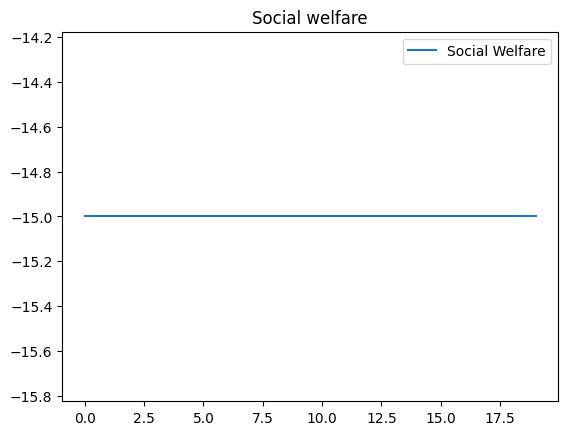

In [46]:
plot_social_welfare(step_stats)

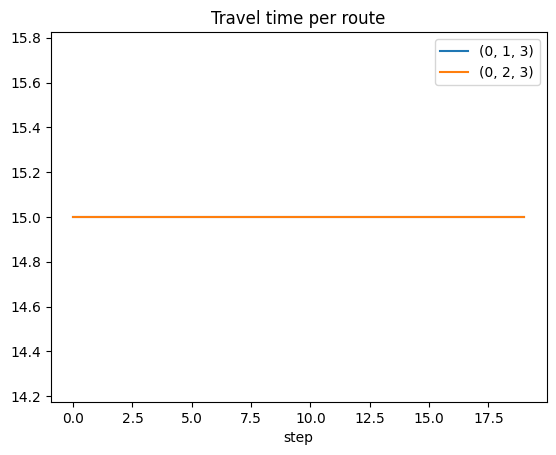

In [47]:
plot_travel_time_per_route(car_stats)

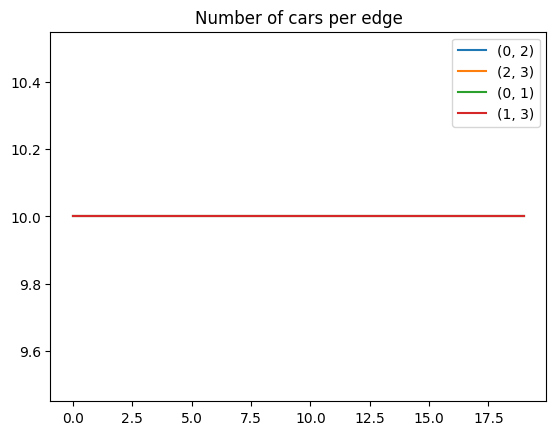

In [48]:
plot_cars_per_edge(car_stats)

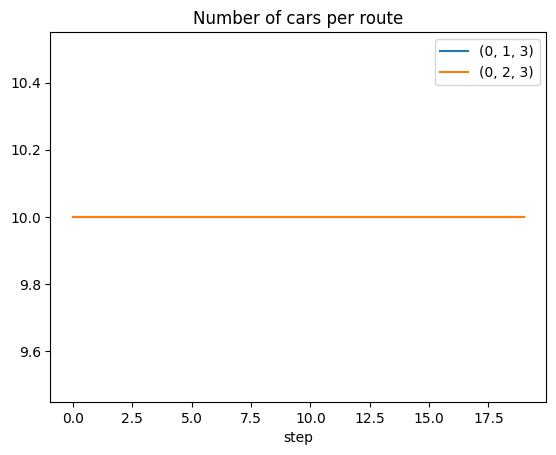

In [49]:
plot_cars_per_route(car_stats)

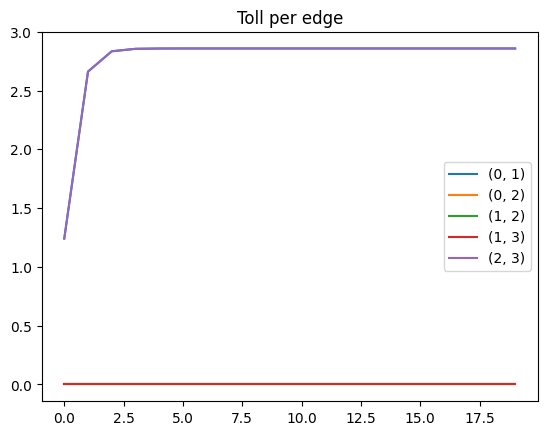

In [50]:
plot_toll_per_edge(step_stats)

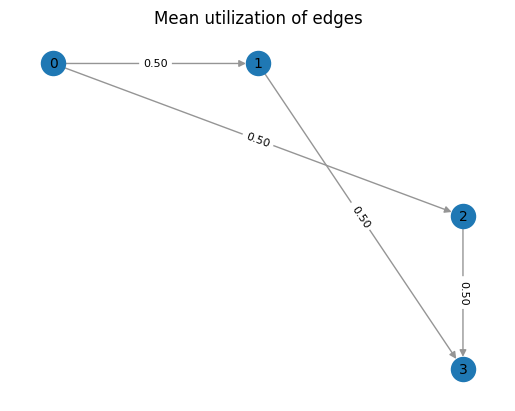

In [51]:
draw_edge_utilization(model, car_stats)

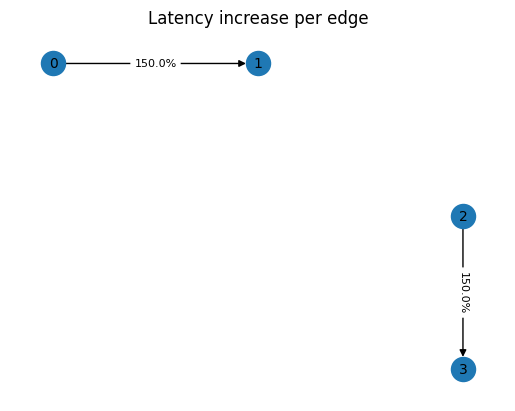

In [52]:
plot_latency_increase_per_edge(model, step_stats)